In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import pickle
import numpy as np
import keras
import keras.models as models
from keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers import GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D,ZeroPadding3D
from keras.regularizers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf



In [ ]:
file = open("/content/gdrive/Shareddrives/EE5805_Fall2023_Ramachandran/RML2016.10b/RML2016.10b.dat",'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

In [1]:
# Load the dataset ...
#  You will need to seperately download or generate this file
file_name = "/content/gdrive/Shareddrives/EE5805_Fall2023_Ramachandran/RML2016.10a/RML2016.10a_dict.pkl"

with open(file_name, 'rb') as file:
    Xd = pickle.load(file, encoding='latin1')

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))

X = np.vstack(X)

FileNotFoundError: ignored

---
# Data Spliting
---


In [ ]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
X_train[0].shape

(2, 128)

In [ ]:
n_train = np.transpose(X_train,(0,2,1))
n_test = np.transpose(X_test, (0,2,1))

---
 # Data conversion
---

In [ ]:
I = X_train[:,0,:]
Q = X_train[:,1,:]

A_tr = np.sqrt(I**2 + Q**2)
phi_tr = np.arctan2(Q,I)

print(A_tr.shape)

X_tr_aphi = np.stack([A_tr, phi_tr], axis=1)


(110000, 128)


In [ ]:
I = X_test[:,0,:]
Q = X_test[:,1,:]

A = np.sqrt(I**2 + Q**2)
phi = np.arctan2(Q,I)

X_te_aphi = np.stack([A, phi], axis=1)

---
# Data Augmentation
---

In [ ]:
import math

import numpy as np

THETA_1 = math.pi/2
THETA_2 = math.pi
THETA_3 = (3*math.pi)/2

SIGMA_1 = 0.0005
SIGMA_2 = 0.001
SIGMA_3 = 0.002


def rotate(signals, labels):
    """
        This function creates a list containing three rotated copies of each element in signals. Rotations are done by
        90°, 180° and 270°.

        Args:
            signals: numpy.array of 2x128 matrixes each one representing a signal.
            labels: labels for each signal.

        Returns:
            numpy.array of 2x128 matrixes each one representing a rotated signal.
    """

    # Rotated signal matrix B is obtained by multiplication of T transformation matrix with A original signal matrix.
    #
    # B = TxA
    #
    # T is defined as shown below.
    #
    # | cos(theta)  -sin(theta) |
    # | sin(theta)   cos(theta) |

    def T(theta):
        return np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

    T_1 = T(THETA_1)
    T_2 = T(THETA_2)
    T_3 = T(THETA_3)

    # list containing rotated signals
    rotated_signals = []
    rotated_labels = []

    # for each signal B = TxA
    for i in range(0, len(signals)):
        A = signals[i]
        l = labels[i]

        # rotate by THETA_1
        B = np.matmul(T_1, A)
        rotated_signals.append(B)
        rotated_labels.append(l)

        # rotate by THETA_2
        B = np.matmul(T_2, A)
        rotated_signals.append(B)
        rotated_labels.append(l)

        # rotate by THETA_3
        B = np.matmul(T_3, A)
        rotated_signals.append(B)
        rotated_labels.append(l)

    return rotated_signals, rotated_labels


In [ ]:
def flip(signals, labels, direction):
    """
        This function creates a list containing a single flipped (horizontally or vertically) copy of each element in
        signals.

        Args:
            signals: numpy.array of 2x128 matrixes each one representing a signal.
            labels: labels for each signal.
            direction: 'horizontal' | 'vertical'

        Returns:
            numpy.array of 2x128 matrixes each one representing a flipped signal.
    """

    flipped = []

    for signal in signals:
        I = signal[0]
        Q = signal[1]

        if direction == "horizontal":
            flipped.append([-I, Q])

        if direction == "vertical":
            flipped.append([I, -Q])

    flipped = np.array(flipped)

    return flipped, labels

In [ ]:
X_train_aug, Y_train_aug = flip(X_train,Y_train,"horizontal")

In [ ]:
X_train_aug.shape

(110000, 2, 128)

In [ ]:
X_train_aug = np.array(X_train_aug)
Y_train_aug = np.array(Y_train_aug)

In [ ]:
X_test_aug, Y_test_aug = flip(X_test,Y_test,"horizontal")

In [ ]:
X_test_aug = np.array(X_test_aug)
Y_test_aug = np.array(Y_test_aug)

---
# Data Normalization
---

In [ ]:
from sklearn.preprocessing import normalize, MinMaxScaler
import numpy as np

# Assuming X_train is your data with shape (110000, 2, 128)

# Extract amplitude and phase
amplitude_data = X_train[:, 0, :]  # Shape: (110000, 128)
phase_data = X_train[:, 1, :]  # Shape: (110000, 128)

# Apply L2 normalization to amplitude
normalized_amplitude = normalize(amplitude_data, norm='l2')  # Shape: (110000, 128)

# Apply arc tan normalization to phase
normalized_phase = np.arctan(phase_data) # Shape: (110000, 128)

# Combine the normalized amplitude and phase
X_tr_norm = np.stack([normalized_amplitude, normalized_phase], axis=1)  # Shape: (110000, 2, 128)

# Check the shape of the resulting normalized data
print(X_tr_norm.shape)


(110000, 2, 128)


In [ ]:
X1_train=np.expand_dims(X_tr_norm[:,0,:], axis=2)
X2_train=np.expand_dims(X_tr_norm[:,1,:], axis=2)
X3_train=np.expand_dims(X_tr_norm,axis=3)


In [ ]:
X3_train.shape

(110000, 2, 128, 1)

In [ ]:
x_tr_mc = [X3_train,X1_train,X2_train]

---
# Test Data Normalization
---


In [ ]:
X_test.shape

(110000, 2, 128)

In [ ]:
# Assuming X_test is your test data with shape (110000, 2, 128)
# Assuming normalized_amplitude and normalized_phase are obtained from the training data

# Extract amplitude and phase from test data
amplitude_test = X_test[:, 0, :]
phase_test = X_test[:, 1, :]

# Apply L2 normalization to amplitude using parameters from training data
normalized_amplitude_test = normalize(amplitude_test, norm='l2', axis=1, copy=True, return_norm=False)

# Apply MinMax normalization to phase using parameters from training data
normalized_phase_test = np.arctan(phase_test)

# Combine the normalized amplitude and phase
X_te_norm = np.stack([normalized_amplitude_test, normalized_phase_test], axis=1)  # Shape: (110000, 2, 128)

# Check the shape of the resulting normalized test data
print(X_te_norm.shape)


(110000, 2, 128)


In [ ]:
X1_test=np.expand_dims(X_te_norm[:,0,:], axis=2)
X2_test=np.expand_dims(X_te_norm[:,1,:], axis=2)
X3_test=np.expand_dims(X_te_norm,axis=3)

In [ ]:
x_te_mc =[X3_test,X1_test,X2_test]

In [ ]:
lbl[83808][1]

a = [lbl[i][0] for i in range(len(lbl))]
len(set(a))

11

In [ ]:
Reshape([1]+in_shp, input_shape=in_shp)

# CNN


In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape[1:], in_shp)
classes = mods



(2, 128) [2, 128]


In [ ]:
# Build VT-CNN2 Neural Net model using Keras primitives --
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
model.add(Convolution2D(256, 1, 3,padding='valid', activation="relu", name="conv1",kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, (1, 3), activation="relu",padding='valid', name="conv2",kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 1, 6, 128)         0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 1, 2, 256)         33024     
                                                                 
 dropout (Dropout)           (None, 1, 2, 256)         0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 1, 6, 256)         0         
 ing2D)                                                          
                                                                 
 conv2 (Conv2D)              (None, 1, 4, 80)          6

In [ ]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size


In [ ]:
filepath = '/content/gdrive/Shareddrives/EE5805_Fall2023_Ramachandran/convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
821/821 - 81s - loss: 1.8777 - accuracy: 0.2516 - val_loss: 1.6756 - val_accuracy: 0.3295 - 81s/epoch - 98ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


821/821 - 73s - loss: 1.7269 - accuracy: 0.3085 - val_loss: 1.6500 - val_accuracy: 0.3379 - 73s/epoch - 89ms/step
Epoch 3/100
821/821 - 76s - loss: 1.7047 - accuracy: 0.3164 - val_loss: 1.6308 - val_accuracy: 0.3435 - 76s/epoch - 93ms/step
Epoch 4/100
821/821 - 72s - loss: 1.6905 - accuracy: 0.3218 - val_loss: 1.6176 - val_accuracy: 0.3446 - 72s/epoch - 87ms/step
Epoch 5/100
821/821 - 77s - loss: 1.6802 - accuracy: 0.3249 - val_loss: 1.6031 - val_accuracy: 0.3485 - 77s/epoch - 94ms/step
Epoch 6/100
821/821 - 72s - loss: 1.6708 - accuracy: 0.3280 - val_loss: 1.5952 - val_accuracy: 0.3532 - 72s/epoch - 88ms/step
Epoch 7/100
821/821 - 72s - loss: 1.6641 - accuracy: 0.3308 - val_loss: 1.5928 - val_accuracy: 0.3541 - 72s/epoch - 87ms/step
Epoch 8/100
821/821 - 77s - loss: 1.6591 - accuracy: 0.3332 - val_loss: 1.5813 - val_accuracy: 0.3571 - 77s/epoch - 93ms/step
Epoch 9/100
821/821 - 75s - loss: 1.6537 - accuracy: 0.3336 - val_loss: 1.5861 - val_accuracy: 0.3565 - 75s/epoch - 91ms/step
Epoc

In [ ]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)
print(score)

352/352 [==============================] - 14s 39ms/step - loss: 1.4780 - accuracy: 0.4090
[1.477982997894287, 0.40901389718055725]


352/352 [==============================] - 10s 29ms/step


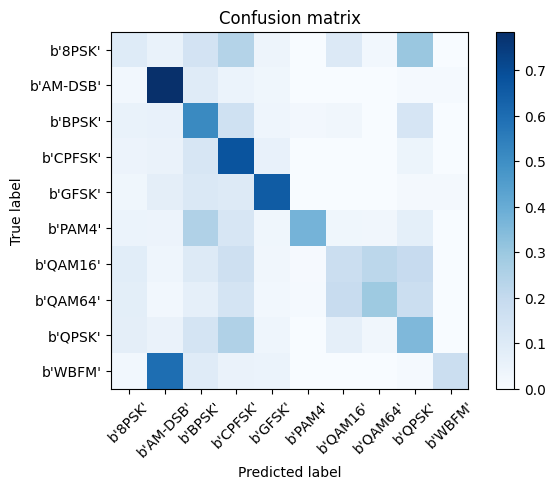

In [ ]:
# Plot confusion matrix CNN
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

567/567 [==============================] - 1s 3ms/step
Overall Accuracy:  0.10478083250524456
561/561 [==============================] - 2s 4ms/step
Overall Accuracy:  0.10875509179175269
561/561 [==============================] - 3s 5ms/step
Overall Accuracy:  0.10890536998828974
560/560 [==============================] - 2s 4ms/step
Overall Accuracy:  0.12807771760370723
565/565 [==============================] - 2s 3ms/step
Overall Accuracy:  0.14010517575422088
563/563 [==============================] - 1s 3ms/step
Overall Accuracy:  0.1773593290007221
566/566 [==============================] - 2s 4ms/step
Overall Accuracy:  0.2260311843414796
559/559 [==============================] - 4s 7ms/step
Overall Accuracy:  0.31446470522429804
564/564 [==============================] - 3s 6ms/step
Overall Accuracy:  0.4173826284574026
560/560 [==============================] - 3s 5ms/step
Overall Accuracy:  0.5059513830678961
562/562 [==============================] - 2s 3ms/step
Overall A

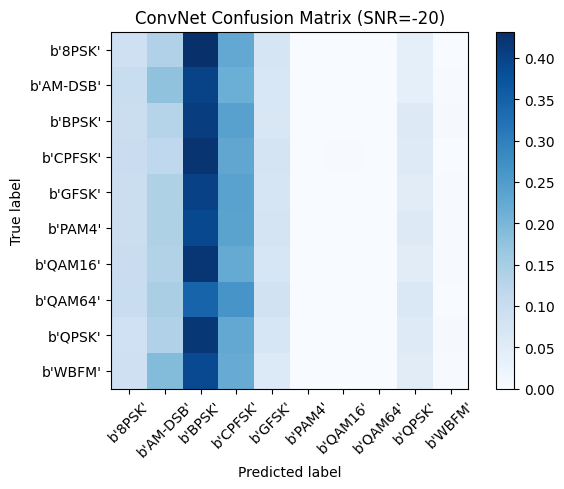

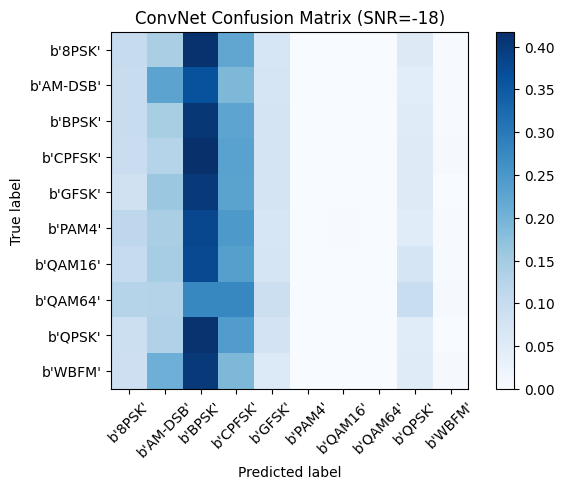

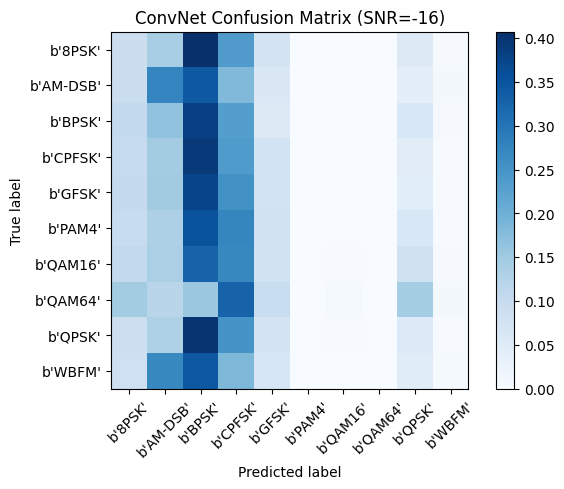

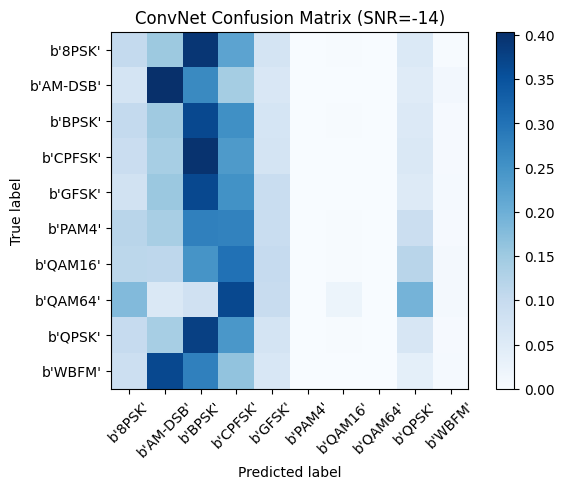

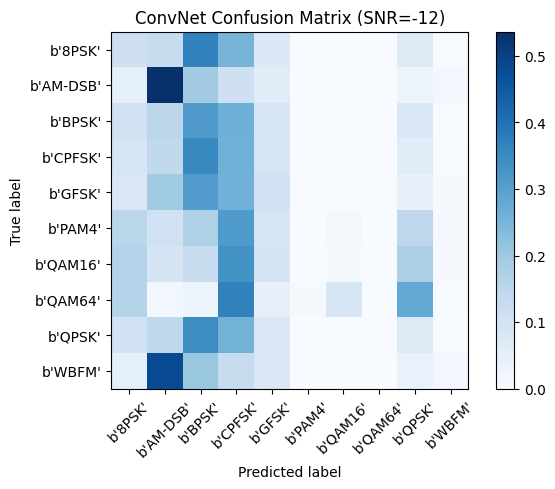

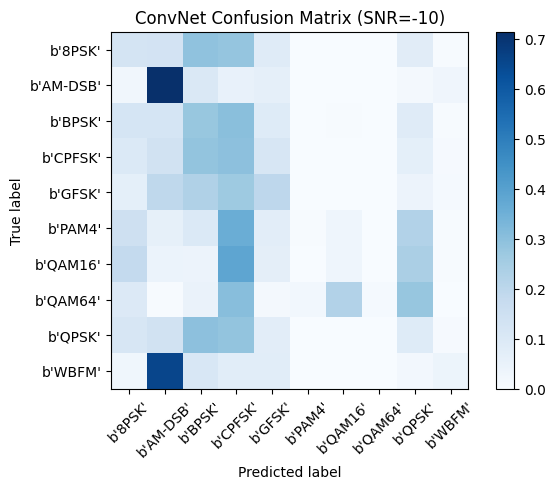

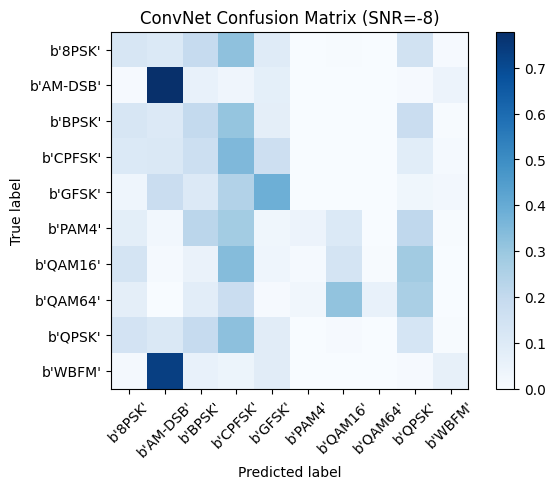

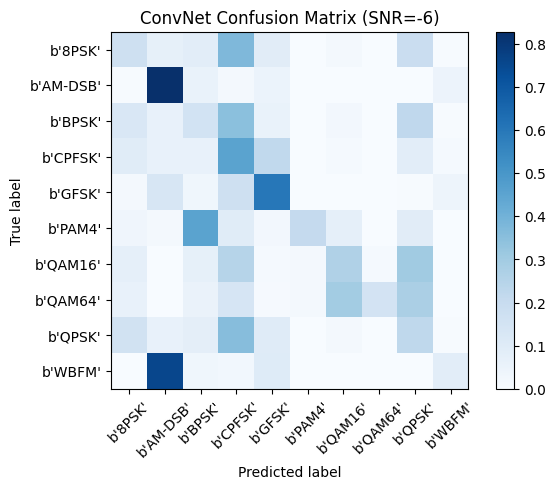

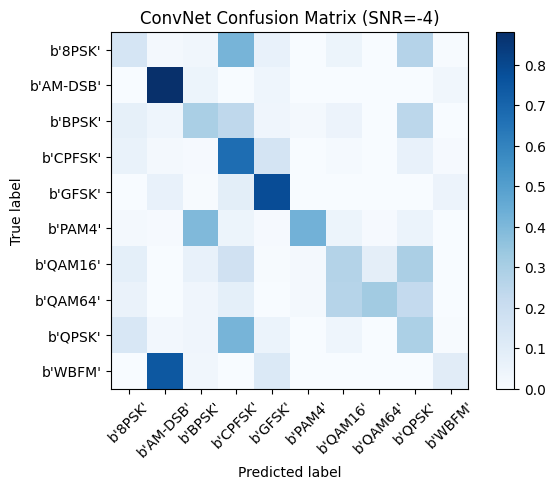

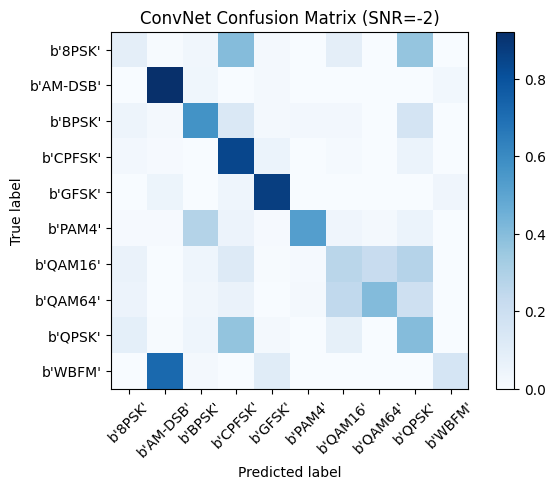

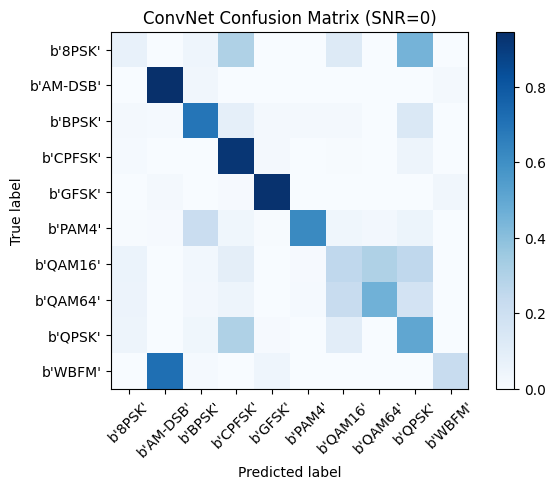

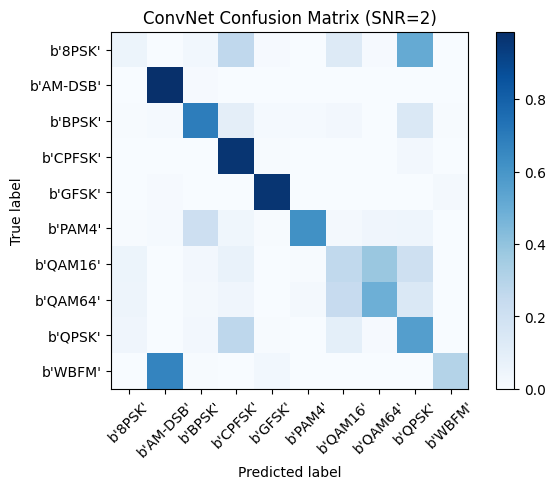

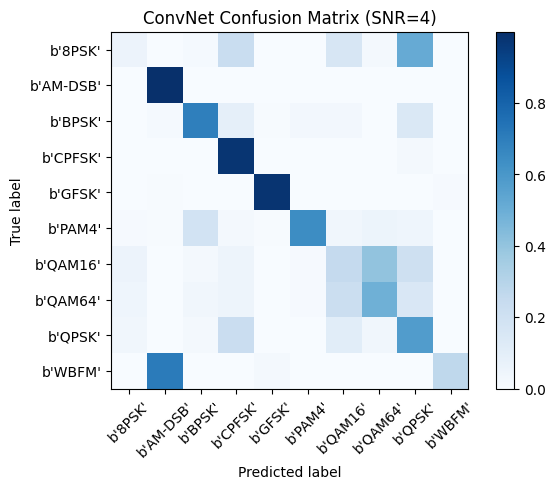

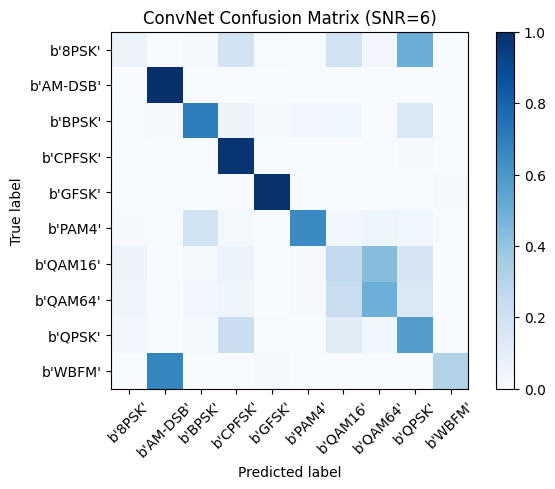

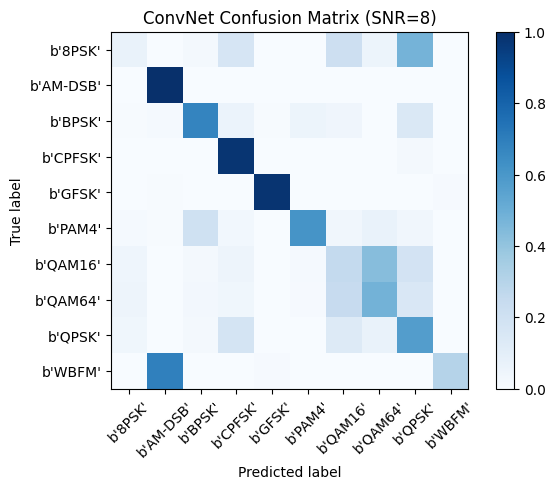

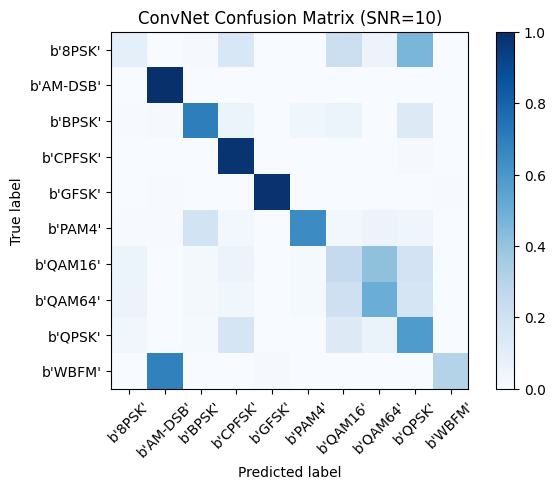

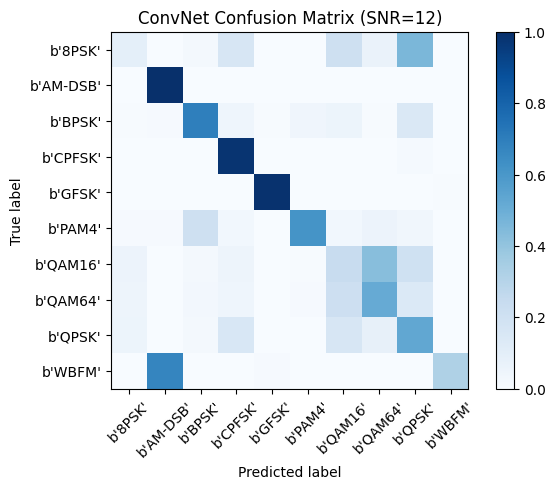

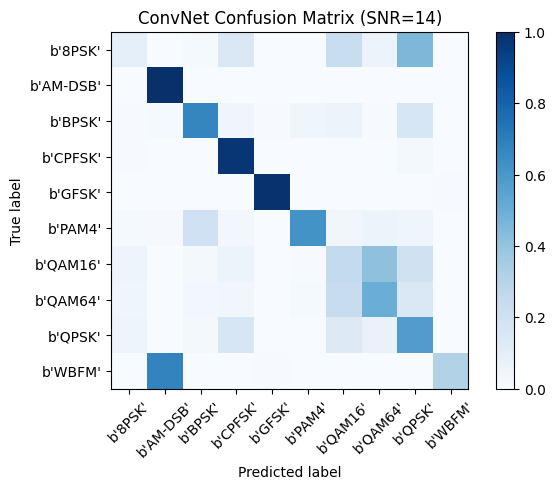

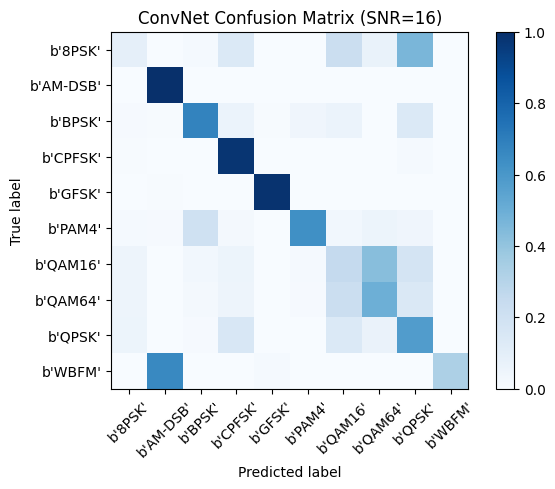

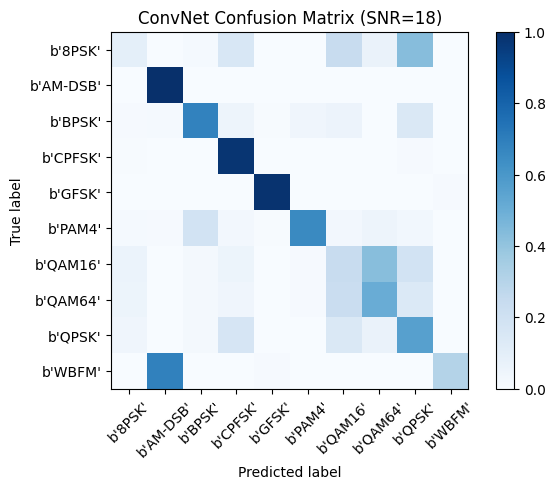

In [ ]:
# Plot confusion matrix CNN
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy')

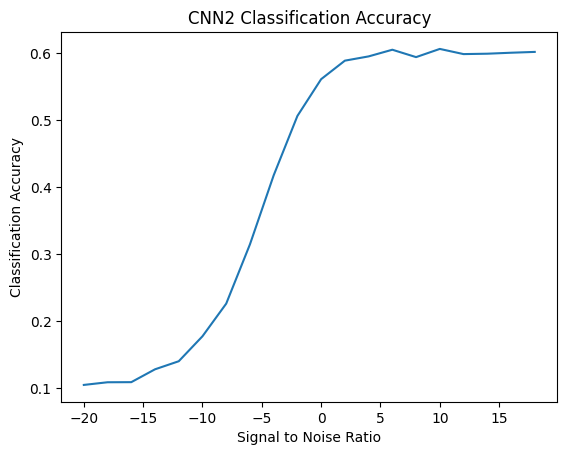

In [ ]:
# Plot accuracy curve CNN
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy")

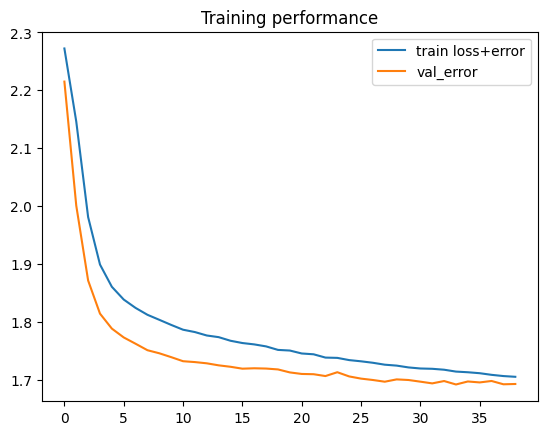

In [ ]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

---
# Time Series Analysis
---


RNN architectures like LSTM and TCN has been performed to capture the temporal characteristics in the signal.

---
# 1. CONVLSTM
---


In [ ]:
!pip install keras-tcn


In [ ]:
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D, Dense
import keras

input_shape = (2,1,1,128)
model9 = keras.models.Sequential()
model9.add(ConvLSTM2D(64, (1, 3), activation="relu",input_shape=input_shape,strides=1,padding="same"))
model9.add(keras.layers.Flatten())
model9.add(Dense(256, activation='relu'))
model9.add(keras.layers.Dropout(0.3))
model9.add(Dense(11, activation="relu"))
model9.add(Dense(11, activation="softmax"))
model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model9.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 1, 64)          147712    
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 256)               16640     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 11)                2827      
                                                                 
 dense_23 (Dense)            (None, 11)                132       
                                                                 
Total params: 167311 (653.56 KB)
Trainable params: 16

In [ ]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.7
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [ ]:
from keras.utils import to_categorical

X_train = X_train.reshape(840000,2,1,128)
Y_train = to_categorical(Y_train[:,0], num_classes=11)
Y_train = Y_train.astype(int);

X_test = X_test.reshape(360000,2,1,128)
Y_test = to_categorical(Y_test[:,0], num_classes=11)
Y_test = Y_test.astype(int);

X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [ ]:
# Train the model (replace X_train with your input data)
filepath = '/content/gdrive/Shareddrives/EE5805_Fall2023_Ramachandran/convlstm.h5'
model9.fit(X_train,
           Y_train, epochs=300,
           batch_size=400,
           verbose=2,
           validation_split=0.2,
           callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
    ])

Epoch 1/300
1680/1680 - 75s - loss: 0.3201 - accuracy: 0.8944 - val_loss: 0.2910 - val_accuracy: 0.8995 - 75s/epoch - 45ms/step
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1680/1680 - 75s - loss: 0.2866 - accuracy: 0.9000 - val_loss: 0.2852 - val_accuracy: 0.8995 - 75s/epoch - 45ms/step
Epoch 3/300
1680/1680 - 66s - loss: 0.2782 - accuracy: 0.9000 - val_loss: 0.2823 - val_accuracy: 0.8995 - 66s/epoch - 39ms/step
Epoch 4/300
1680/1680 - 56s - loss: 0.2718 - accuracy: 0.9000 - val_loss: 0.2800 - val_accuracy: 0.8995 - 56s/epoch - 33ms/step
Epoch 5/300
1680/1680 - 54s - loss: 0.2682 - accuracy: 0.9000 - val_loss: 0.2789 - val_accuracy: 0.8995 - 54s/epoch - 32ms/step
Epoch 6/300
1680/1680 - 56s - loss: 0.2660 - accuracy: 0.9000 - val_loss: 0.2820 - val_accuracy: 0.8995 - 56s/epoch - 33ms/step
Epoch 7/300
1680/1680 - 52s - loss: 0.2647 - accuracy: 0.9000 - val_loss: 0.2819 - val_accuracy: 0.8995 - 52s/epoch - 31ms/step
Epoch 8/300
1680/1680 - 53s - loss: 0.2634 - accuracy: 0.9000 - val_loss: 0.2811 - val_accuracy: 0.8995 - 53s/epoch - 32ms/step
Epoch 9/300
1680/1680 - 52s - loss: 0.2625 - accuracy: 0.9000 - val_loss: 0.2815 - val_accuracy: 0.8995 - 52s/epoch 

KeyboardInterrupt: ignored

In [ ]:
filepath = '/content/gdrive/Shareddrives/EE5805_Fall2023_Ramachandran/convlstm.h5'
model9.load_weights(filepath)

ValueError: ignored

---
# LSTM
---
Long Short-Term Memory

In [ ]:
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
from keras.models import Sequential


model4 = Sequential()


model4.add(LSTM(64, dropout = 0.3, return_sequences = True, recurrent_dropout = 0.3, input_shape = list(X_train.shape[1:])))
model4.add(Flatten())
model4.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model4.add(Dense(10, activation = 'softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 2, 64)             49408     
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 67210 (262.54 KB)
Trainable params: 67210 (262.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model (replace X_train with your input data)
filepath = '/content/gdrive/Shareddrives/EE5805_Fall2023_Ramachandran/lstm11.h5'
model4.fit(X_train,
           Y_train, epochs=300,
           batch_size=400,
           verbose=2,
           validation_split=0.2,
           callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

Epoch 1/300
1680/1680 - 38s - loss: 2.0598 - accuracy: 0.1988 - val_loss: 2.0116 - val_accuracy: 0.2133 - 38s/epoch - 22ms/step
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1680/1680 - 38s - loss: 2.0098 - accuracy: 0.2181 - val_loss: 1.9788 - val_accuracy: 0.2351 - 38s/epoch - 22ms/step
Epoch 3/300
1680/1680 - 35s - loss: 1.9715 - accuracy: 0.2358 - val_loss: 1.9437 - val_accuracy: 0.2489 - 35s/epoch - 21ms/step
Epoch 4/300
1680/1680 - 35s - loss: 1.9448 - accuracy: 0.2454 - val_loss: 1.9149 - val_accuracy: 0.2575 - 35s/epoch - 21ms/step
Epoch 5/300
1680/1680 - 35s - loss: 1.9163 - accuracy: 0.2552 - val_loss: 1.8765 - val_accuracy: 0.2678 - 35s/epoch - 21ms/step
Epoch 6/300
1680/1680 - 37s - loss: 1.8780 - accuracy: 0.2666 - val_loss: 1.8410 - val_accuracy: 0.2788 - 37s/epoch - 22ms/step
Epoch 7/300
1680/1680 - 35s - loss: 1.8485 - accuracy: 0.2740 - val_loss: 1.8136 - val_accuracy: 0.2842 - 35s/epoch - 21ms/step
Epoch 8/300
1680/1680 - 35s - loss: 1.8174 - accuracy: 0.2810 - val_loss: 1.7785 - val_accuracy: 0.2925 - 35s/epoch - 21ms/step
Epoch 9/300
1680/1680 - 35s - loss: 1.7858 - accuracy: 0.2889 - val_loss: 1.7476 - val_accuracy: 0.2969 - 35s/epoch 

KeyboardInterrupt: ignored

In [ ]:
score = model4.evaluate(X_test, Y_test, verbose=1, batch_size=400)
print(score)

900/900 [==============================] - 7s 8ms/step - loss: 1.3637 - accuracy: 0.4339
[1.3636881113052368, 0.4338555634021759]


In [ ]:
model4.load_weights('/content/gdrive/Shareddrives/EE5805_Fall2023_Ramachandran/lstm11.h5')

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

900/900 [==============================] - 5s 6ms/step


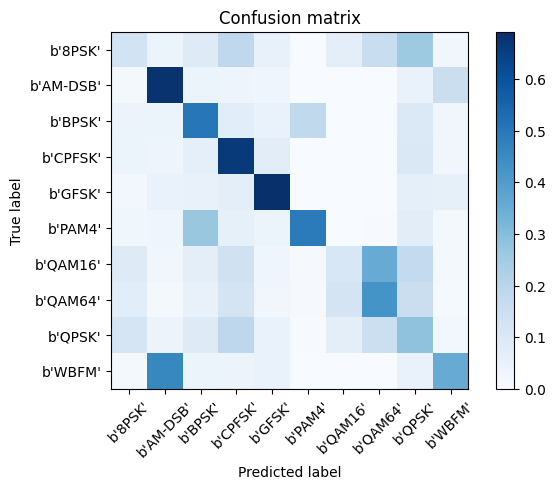

In [ ]:
# Plot confusion matrix
test_Y_hat = model4.predict(X_test, batch_size=400)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

567/567 [==============================] - 2s 3ms/step
Overall Accuracy:  0.10665783371977476
561/561 [==============================] - 1s 2ms/step
Overall Accuracy:  0.10680207577702137
561/561 [==============================] - 2s 3ms/step
Overall Accuracy:  0.11526236547147717
560/560 [==============================] - 2s 3ms/step
Overall Accuracy:  0.13287923622354977
565/565 [==============================] - 1s 2ms/step
Overall Accuracy:  0.155826183227235
563/563 [==============================] - 2s 3ms/step
Overall Accuracy:  0.21240904293728824
566/566 [==============================] - 1s 2ms/step
Overall Accuracy:  0.28939511224151276
559/559 [==============================] - 1s 2ms/step
Overall Accuracy:  0.3801320058172055
564/564 [==============================] - 2s 3ms/step
Overall Accuracy:  0.48572695526855497
560/560 [==============================] - 2s 3ms/step
Overall Accuracy:  0.5921207041072926
562/562 [==============================] - 1s 2ms/step
Overall A

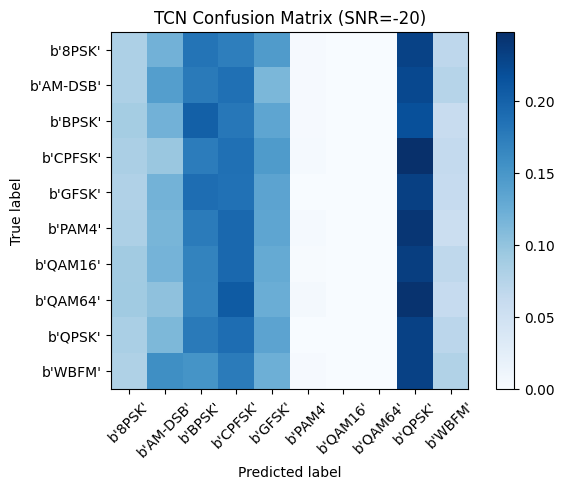

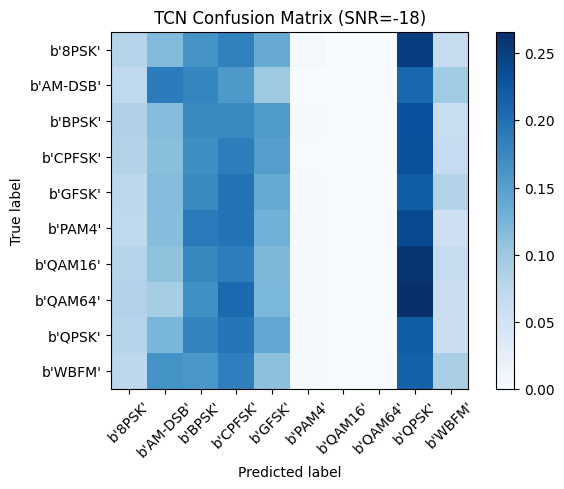

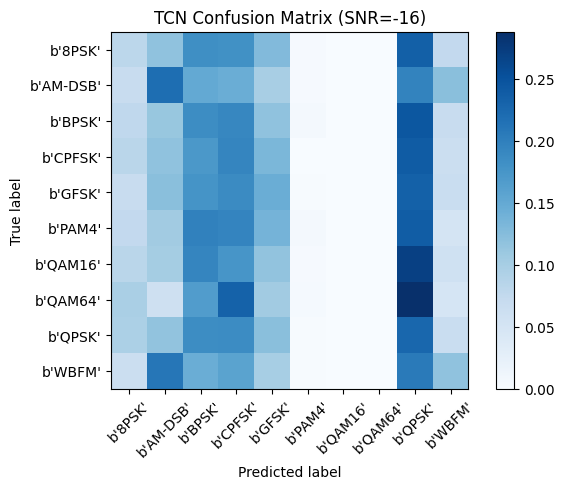

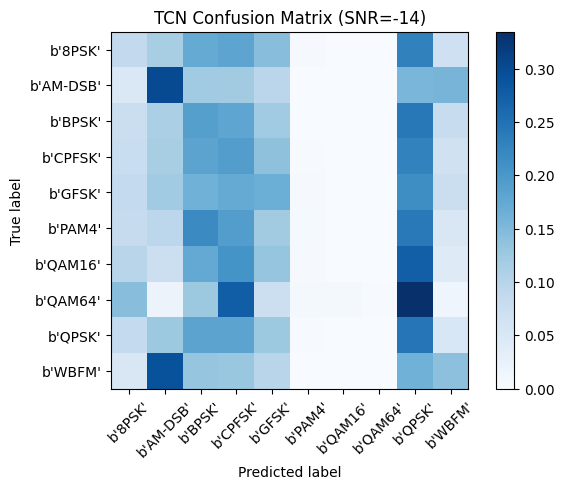

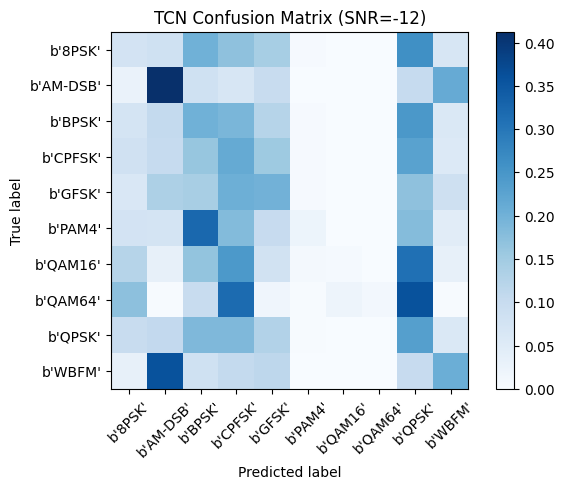

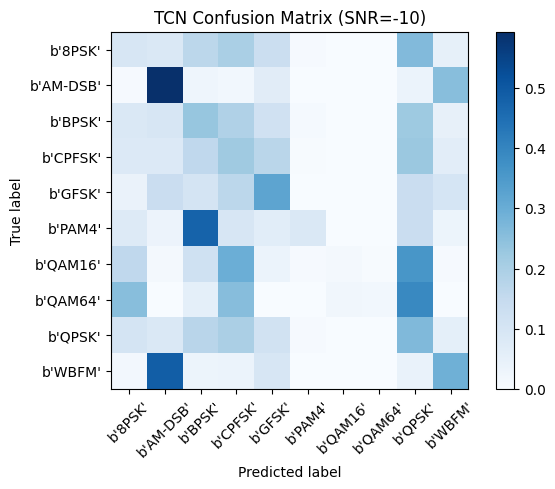

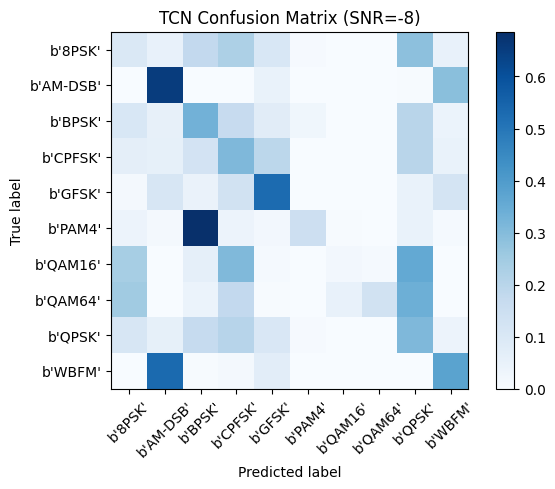

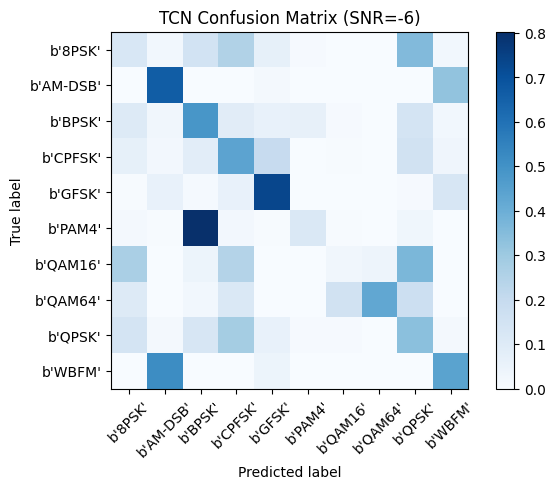

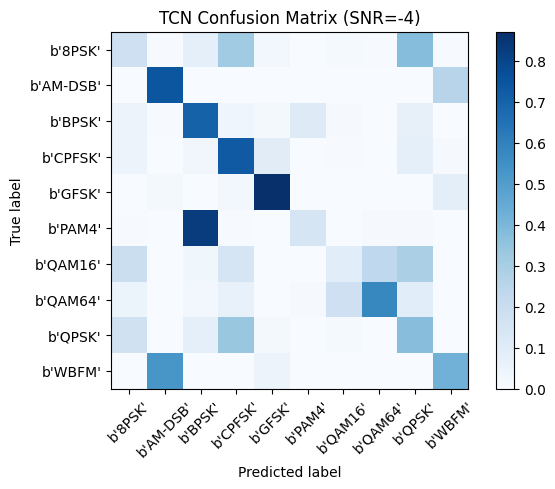

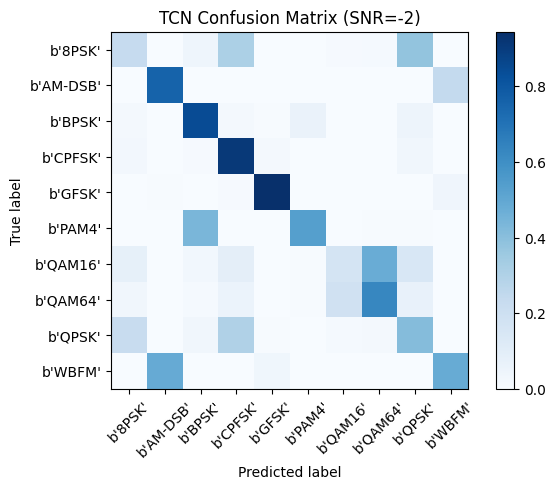

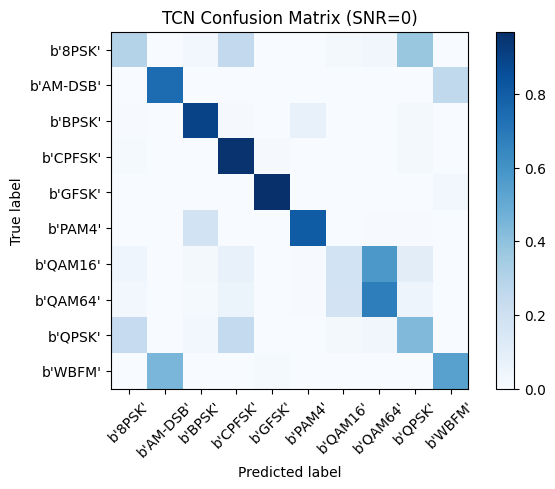

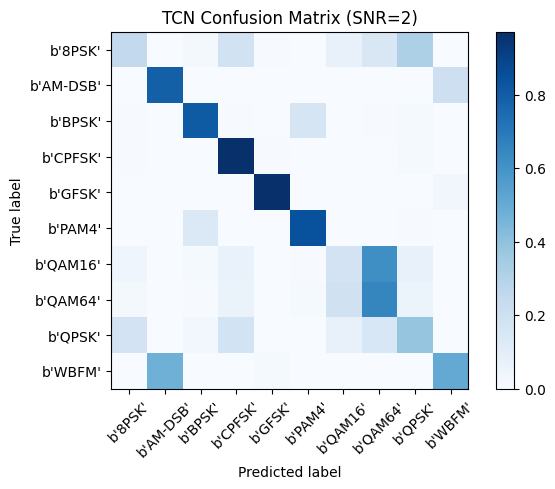

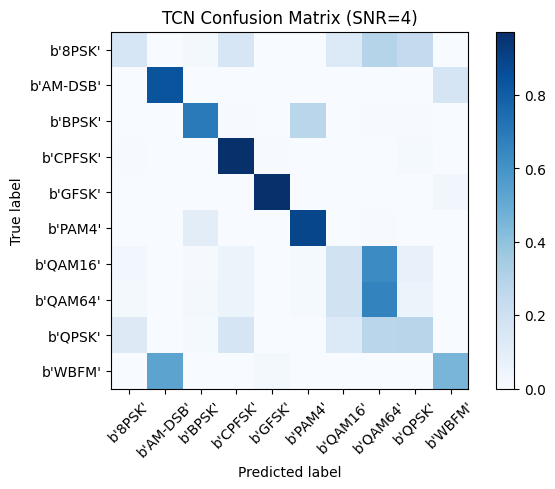

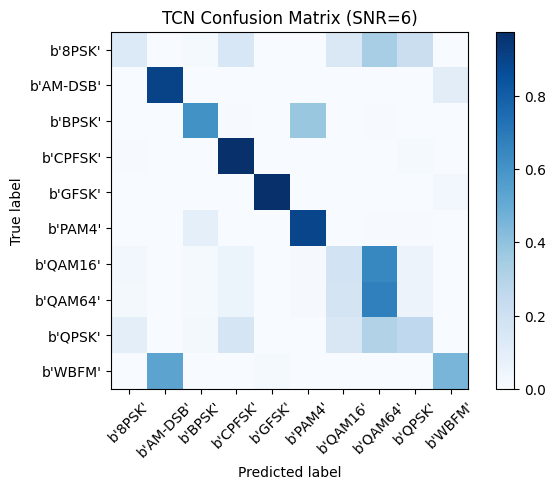

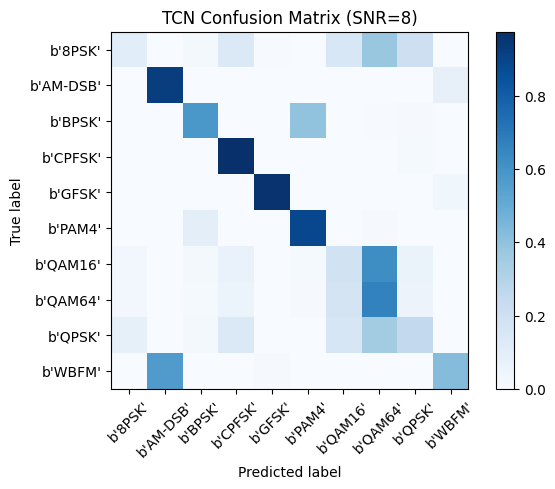

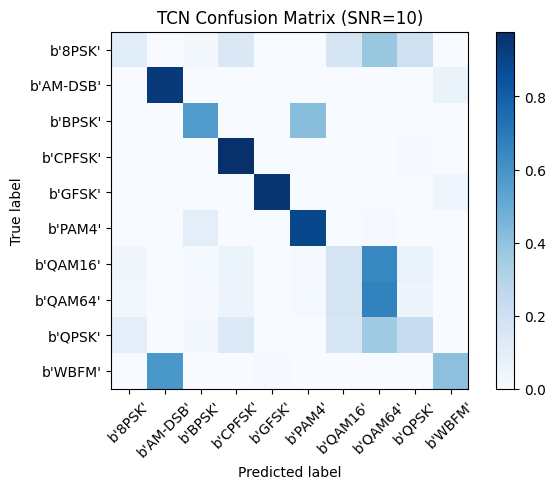

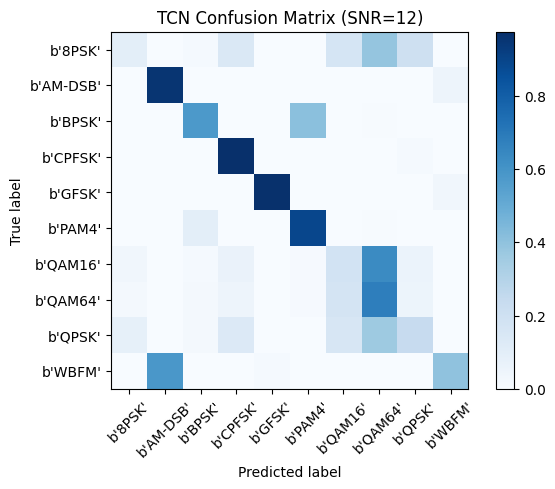

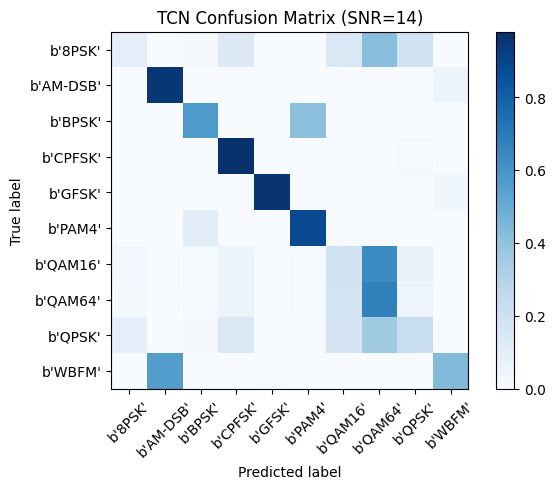

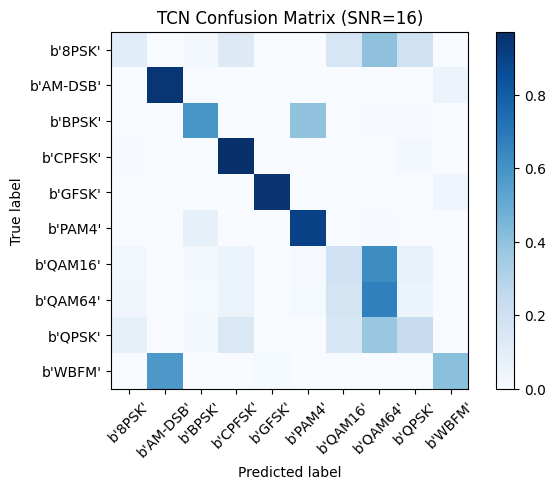

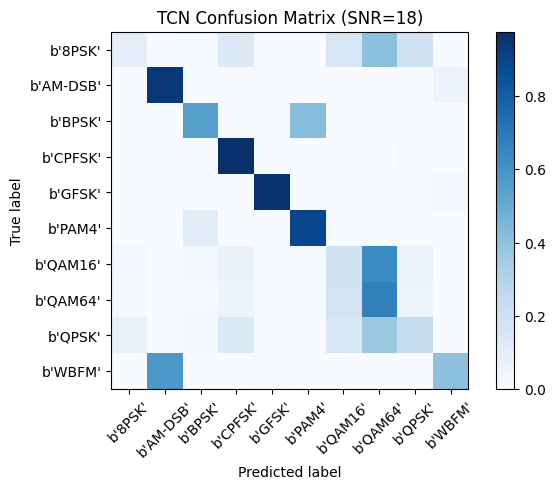

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]

    # estimate classes
    test_Y_i_hat = model4.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="LSTM Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

----
# TCN
----

Temporal Convolutional Network


In [ ]:
#### 40% Accuracy #### ###Do not touch###

from tcn import TCN
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, AveragePooling1D,Dropout
from keras import regularizers

# Assuming your input sequence length is 128
input_shape = (2,128)

model2 = Sequential()
model2.add(Conv1D(64, 3, activation='relu',
                  padding='same',
                  input_shape = input_shape,
                  kernel_regularizer = regularizers.L2(1e-4)))
model2.add(Dropout(0.1))

model2.add(Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer = regularizers.L2(1e-4)))
model2.add(Dropout(0.1))
model2.add(TCN(nb_filters=50,  # Adjusted for consistency
               kernel_size=8,
               nb_stacks=1,
               dilations=[1, 2, 4, 8],
               dropout_rate=0.2,
               padding='causal',
               return_sequences=False,
               activation='relu',
               kernel_initializer='he_normal',
               use_layer_norm=True,
               input_shape=input_shape))  # Include input_shape here

model2.add(Dense(128, activation='relu', kernel_initializer='he_normal',kernel_regularizer = regularizers.L2(1e-4)))
model2.add(Dense(units=10, activation='softmax'))

model2.summary()

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 64)             24640     
                                                                 
 dropout_8 (Dropout)         (None, 2, 64)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 32)             6176      
                                                                 
 dropout_9 (Dropout)         (None, 2, 32)             0         
                                                                 
 tcn_2 (TCN)                 (None, 50)                155650    
                                                                 
 dense_19 (Dense)            (None, 128)               6528      
                                                                 
 dense_20 (Dense)            (None, 10)               

In [ ]:
model2.load_weights('/content/gdrive/Shareddrives/EE5805_Fall2023_Ramachandran/TCN_b_data.h5')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 64)             24640     
                                                                 
 dropout_8 (Dropout)         (None, 2, 64)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 32)             6176      
                                                                 
 dropout_9 (Dropout)         (None, 2, 32)             0         
                                                                 
 tcn_2 (TCN)                 (None, 50)                155650    
                                                                 
 dense_19 (Dense)            (None, 128)               6528      
                                                                 
 dense_20 (Dense)            (None, 10)               

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
score = model2.evaluate(X_test, Y_test, verbose=1, batch_size=400)
print(score)

900/900 [==============================] - 33s 34ms/step - loss: 1.3373 - accuracy: 0.4486
[1.337325930595398, 0.4486444592475891]


900/900 [==============================] - 34s 37ms/step


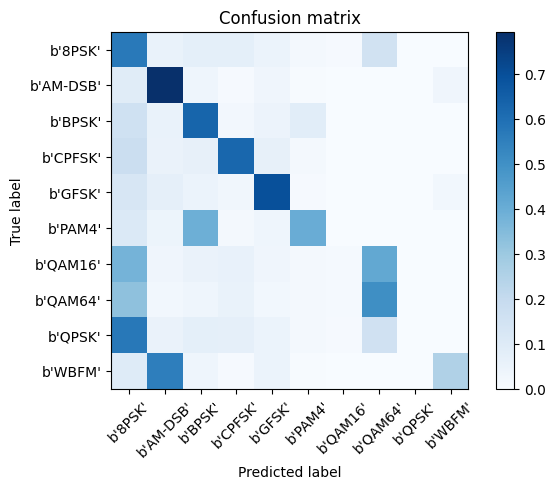

In [ ]:
# Plot confusion matrix
test_Y_hat = model2.predict(X_test, batch_size=400)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

567/567 [==============================] - 12s 15ms/step
Overall Accuracy:  0.10384233189797946
561/561 [==============================] - 6s 11ms/step
Overall Accuracy:  0.1072484794375314
561/561 [==============================] - 5s 8ms/step
Overall Accuracy:  0.11693525901968438
560/560 [==============================] - 4s 7ms/step
Overall Accuracy:  0.13701077550108873
565/565 [==============================] - 6s 10ms/step
Overall Accuracy:  0.17304179352338778
563/563 [==============================] - 4s 8ms/step
Overall Accuracy:  0.24451480308837417
566/566 [==============================] - 6s 11ms/step
Overall Accuracy:  0.3152161893177043
559/559 [==============================] - 5s 8ms/step
Overall Accuracy:  0.37990826714397585
564/564 [==============================] - 4s 8ms/step
Overall Accuracy:  0.46798957929161356
560/560 [==============================] - 6s 11ms/step
Overall Accuracy:  0.5637887678122381
562/562 [==============================] - 4s 7ms/step
Ov

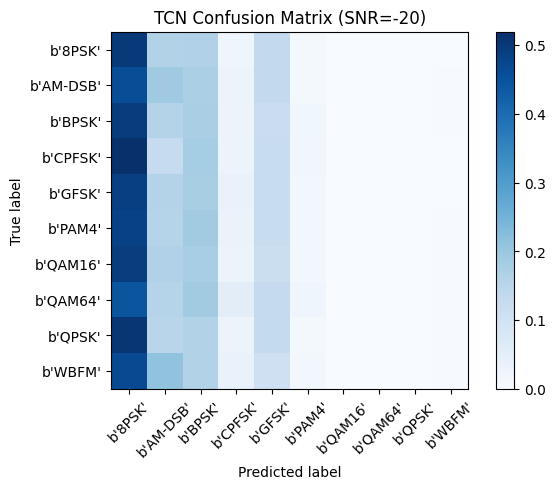

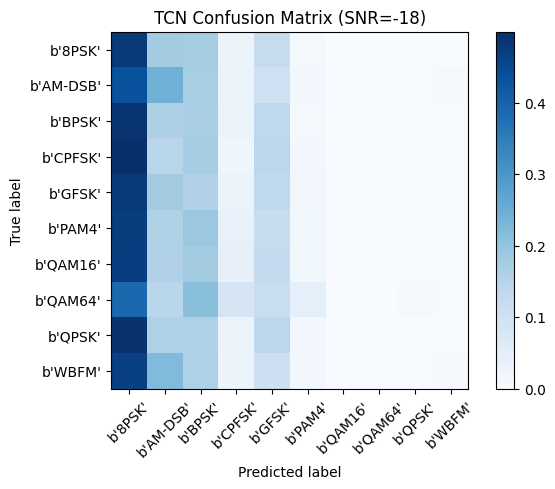

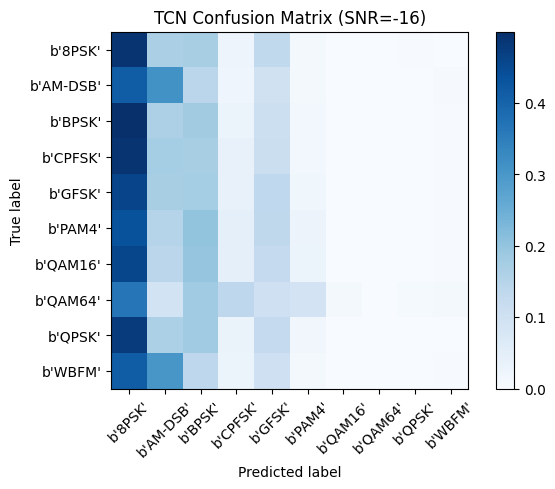

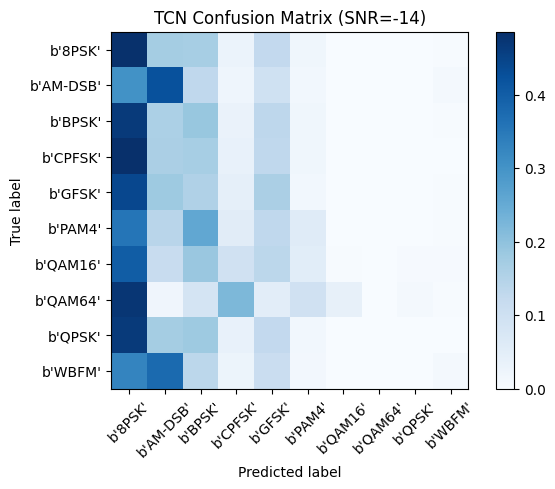

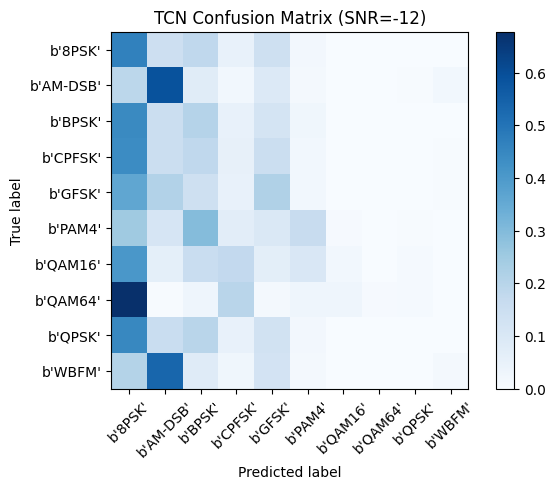

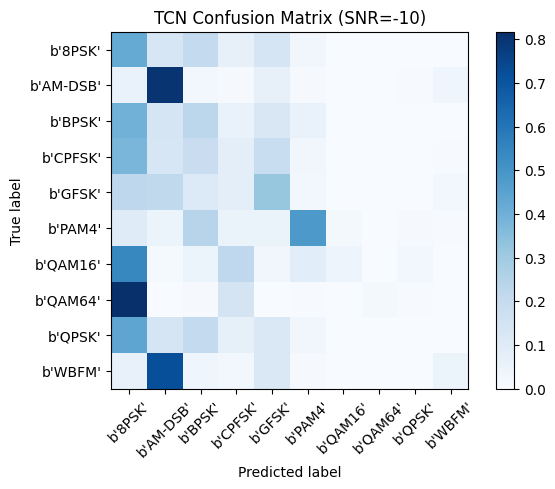

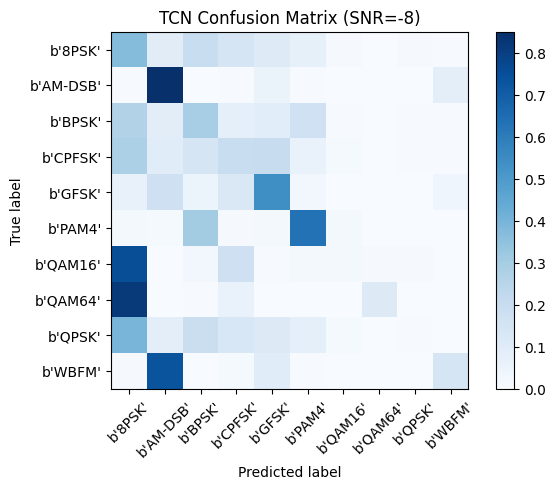

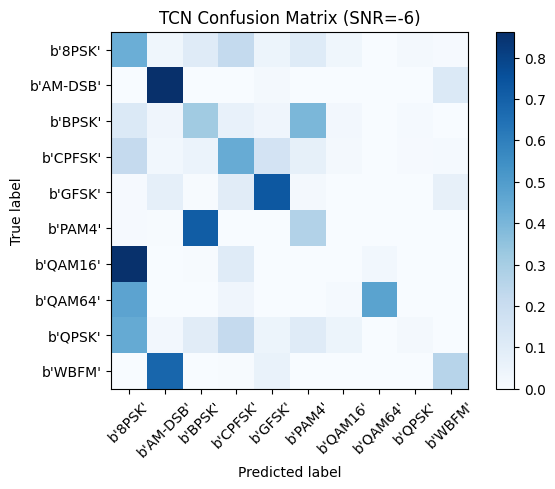

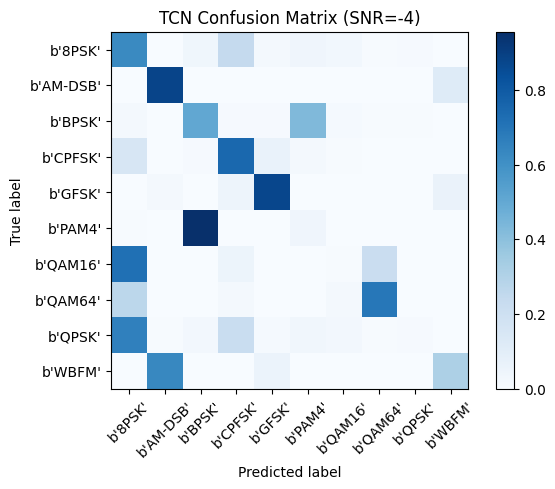

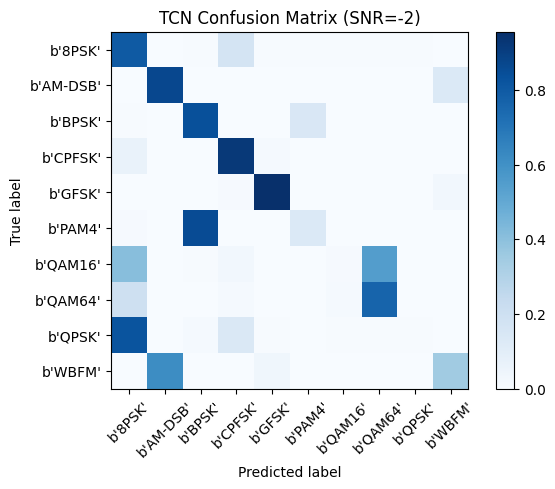

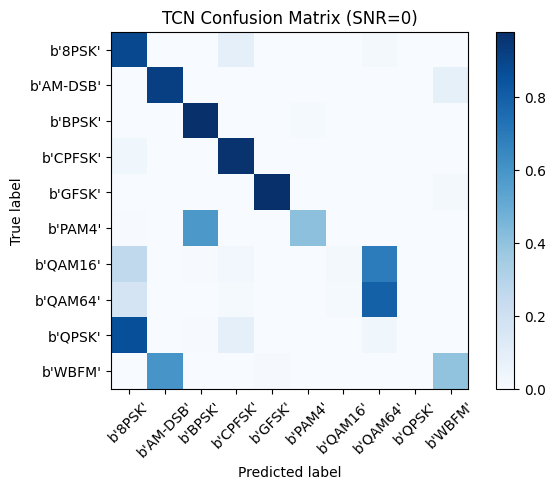

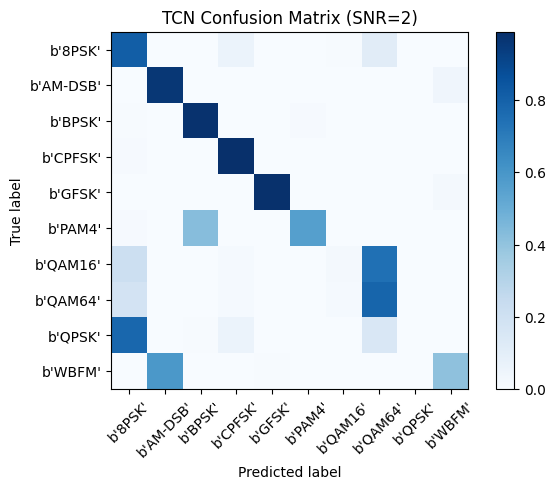

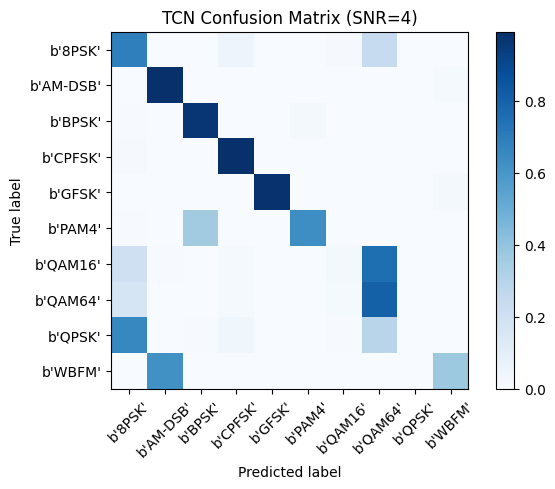

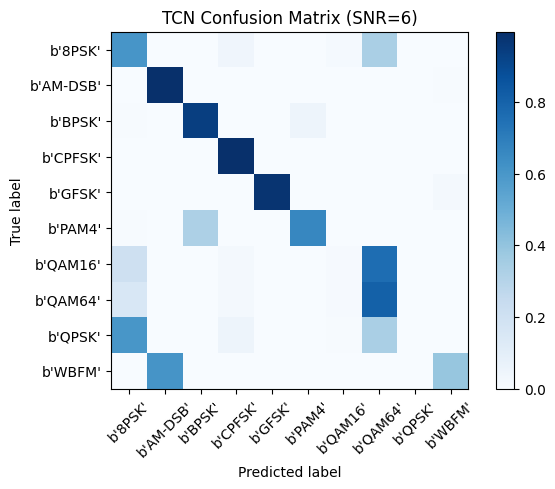

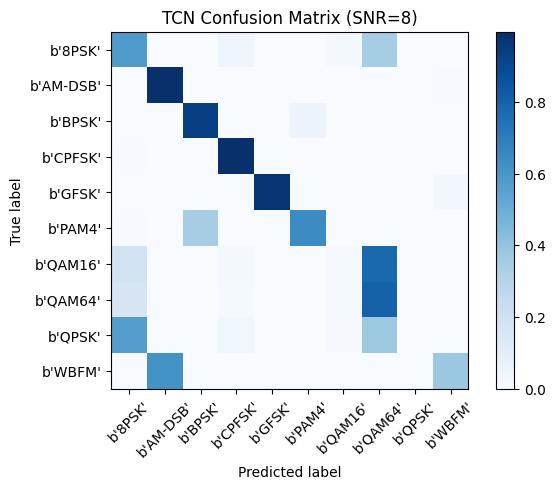

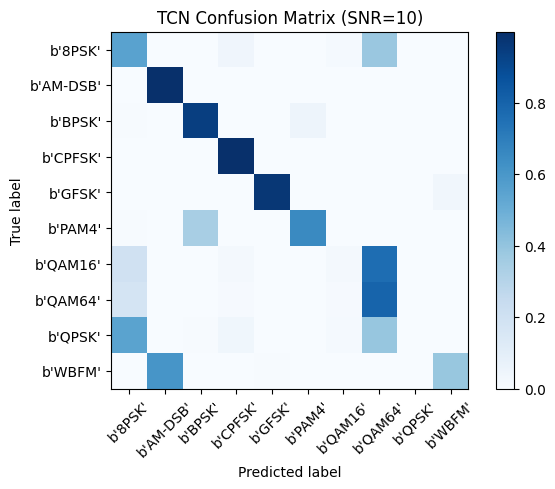

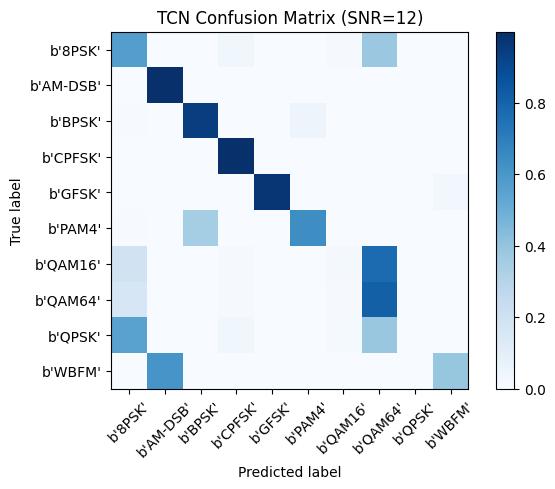

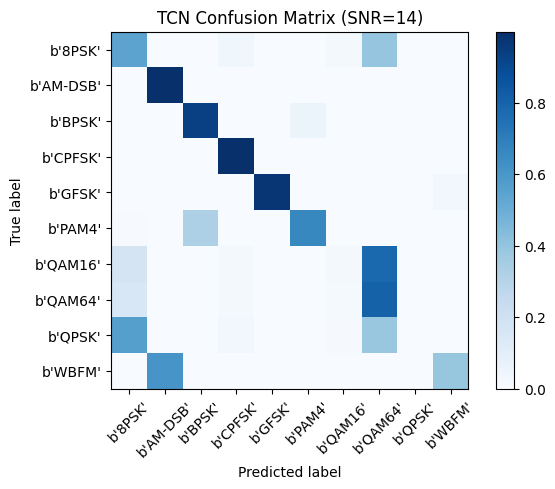

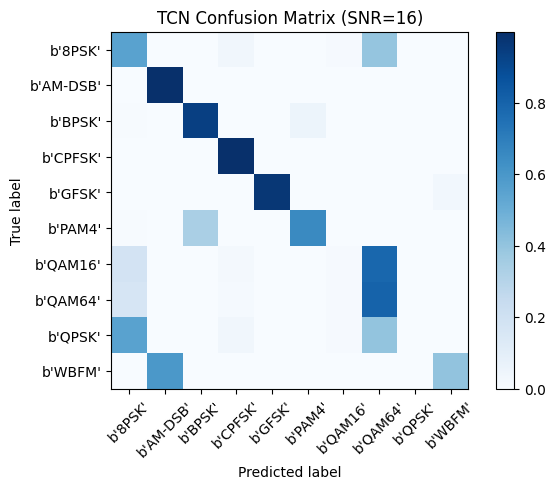

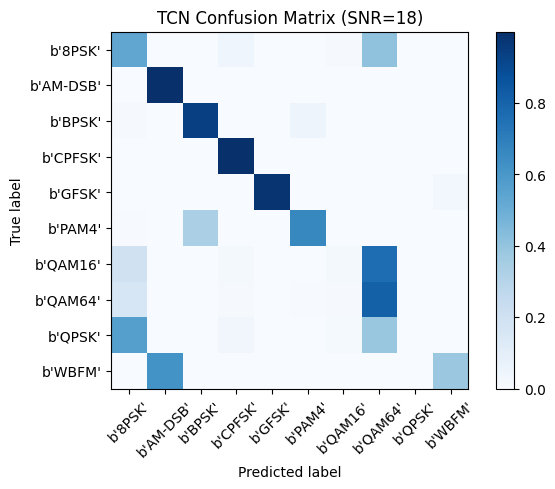

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]

    # estimate classes
    test_Y_i_hat = model2.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="TCN Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'TCN Classification Accuracy')

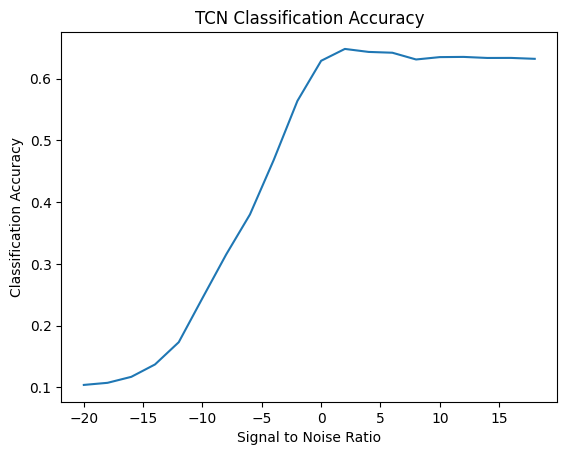

In [ ]:
# Plot accuracy curve TCN
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("TCN Classification Accuracy")

---
End TCN github
---


# Summary

CNN, LSTM and ConvTCN has been compared

**CNN:**

Overall Acc: 0.4090 <br>
Max Acc: 0.605 at SNR= 10db

**LSTM:**

Overall Acc: 0.433 <br>
Max Acc: 0.64 at SNR = 2db

**ConvTCN**

Overall Acc: 0.4486 <br>
Max Acc: 0.648 at SNR = 2db

![alt text](https://drive.google.com/uc?id=17Fup9n3HNM7iMkNqbXZs199lbx_vBcAG)




